Import Libraries

In [2]:
import pandas as pd
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import requests
import os
import fiona
import numpy as np
import shapely
from shapely.geometry import Point

Convert data stored in .csv files in cwd into dictionary objects

In [3]:
listings = pd.read_csv("listings.csv")
review = pd.read_csv("reviews.csv")
neighbourhoods = pd.read_csv("neighbourhoods.csv")

Shows average Cost of a room type & its associated neighbourhood

In [6]:
def storeCostData(main_data):

    info = [] # List of dictionaries

    for x in range(len(main_data["id"])):
        
        if checkExisting(main_data["neighbourhood"][x], main_data["room_type"][x], info) == 0:
            new_dict = {
                "location": main_data["neighbourhood"][x],
                "rtype": main_data["room_type"][x],
                "price": 0,
                "count": 0 # Counts number of similar rtype & location
            }
            info.append(new_dict)
            
    info = countAverage(main_data, info)
            
    return info 
        

def countAverage(main_data, info):
    
    for x in range(len(main_data["id"])):
        loc_name = main_data["neighbourhood"][x]
        loc_rtype = main_data["room_type"][x]
        for curr in info:
            if curr["location"] == loc_name and curr["rtype"] == loc_rtype:
                curr["price"] += main_data["price"][x]
                curr["count"] += 1
                
    for y in info:
        y["price"] = round(y["price"] / y["count"])
                
            
    return info
        
# Function to check whether an neighbour exist in a list already
# and that the same room type also exist with the current neighbour
# If exist return 1, else return 0
def checkExisting(name, rtype, info):
    
    # For list is empty
    if not info:
        return 0
    
    for x in info:
        if x["location"] == name and x["rtype"] == rtype:
            return 1
    
    return 0


# Panda DataFrame to store average_cost information 
avg_cost_data = storeCostData(listings)

print_data = pd.DataFrame(avg_cost_data)
print_data.rename(columns={"count": "Available Rooms", "location": "Location", "price": "Avg. Price per night", "rtype": "Room Type"}, inplace=True)
print_data

,Location,Room Type,Avg. Price per night,Available Rooms
0,Sydney,Private room,113.0,3210
1,Manly,Entire home/apt,339.0,1363
2,Leichhardt,Entire home/apt,286.0,683
3,Woollahra,Private room,94.0,527
4,North Sydney,Entire home/apt,245.0,986
5,Waverley,Entire home/apt,320.0,3507
6,Sydney,Entire home/apt,219.0,6235
7,Mosman,Entire home/apt,451.0,415
8,Pittwater,Entire home/apt,564.0,1051
9,Lane Cove,Private room,92.0,123


Creating map given with neighbourhoods.geojson

In [38]:
# Stores geo data
suburbs = gp.read_file("neighbourhoods.geojson")


# Scales map plot size
%matplotlib inline

# Updates mathplotlib fontsize
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (35, 50)

In [39]:
# Adds a centroid / small circle in the middle of a geometry shape
# Necessary to plot location names in the map
def add_centroid(row):
    return row.geometry.centroid

In [40]:
# Function to add a geometry column into listings 
# storing a Shapely Point
def newGeometry(data_list):
    geo_list = []

    for x in range(len(data_list["longitude"])):
        point = Point(data_list["longitude"][x], data_list["latitude"][x])
        geo_list.append(point)

    data_list["geometry"] = geo_list;

    return data_list

Text(0.5, 0.8, 'NSW Suburb Map')

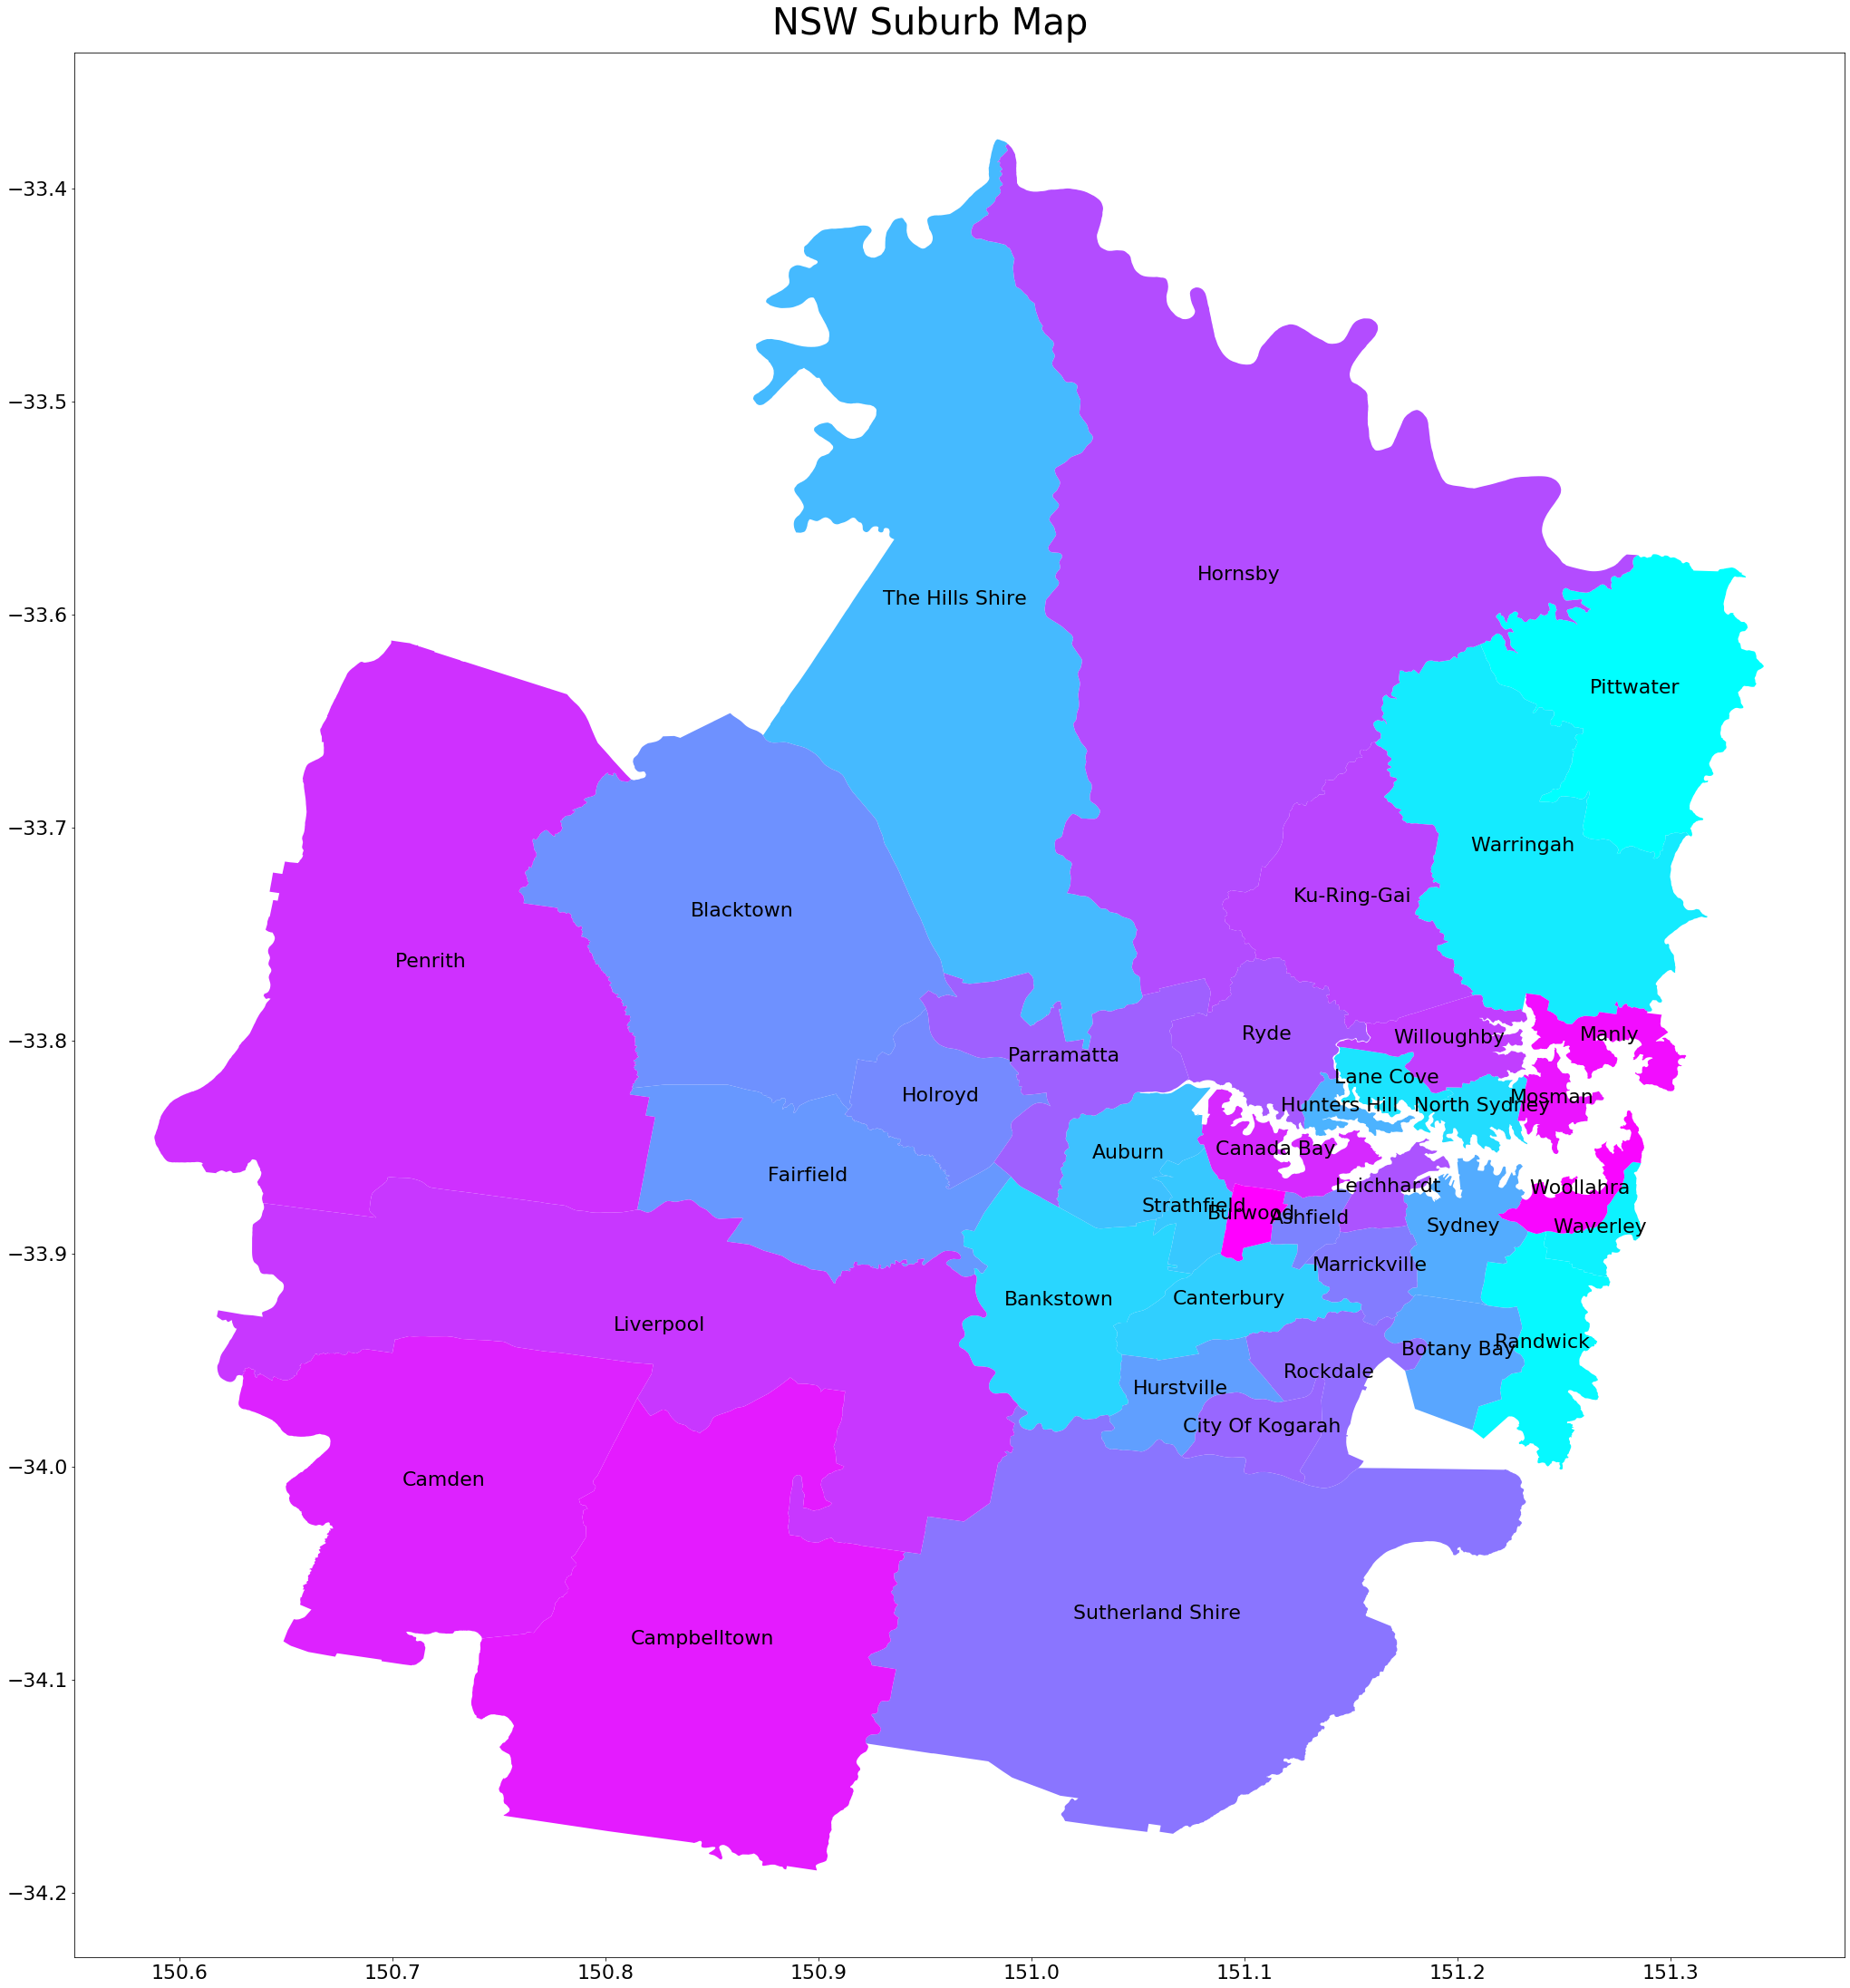

In [62]:
# Set centroid to print location name later
suburbs["centroid"] = suburbs.apply(add_centroid, axis=1)

# Update listings with geometry column for plotting purposes
listings = newGeometry(listings)

# Converts listings DataFrame into Geopanda DataFrame and store it in geo_listings
# geo_listings stores geometry information of available air_bnb rental locations
geo_listings = gp.GeoDataFrame(listings)

# Plot Map
suburbs.plot(cmap="cool")

# Prints suburb name
for idx, row in suburbs.iterrows():
    plt.annotate(s=row.neighbourhood, xy=tuple(row.centroid.coords)[0], 
                 horizontalalignment='center')
    
plt.figtext(.5,0.8,"NSW Suburb Map",fontsize=40,ha='center')

Plots all available AirBnb Rental Locations

Text(0.5, 0.85, 'Available AirBnb Rentals in NSW')

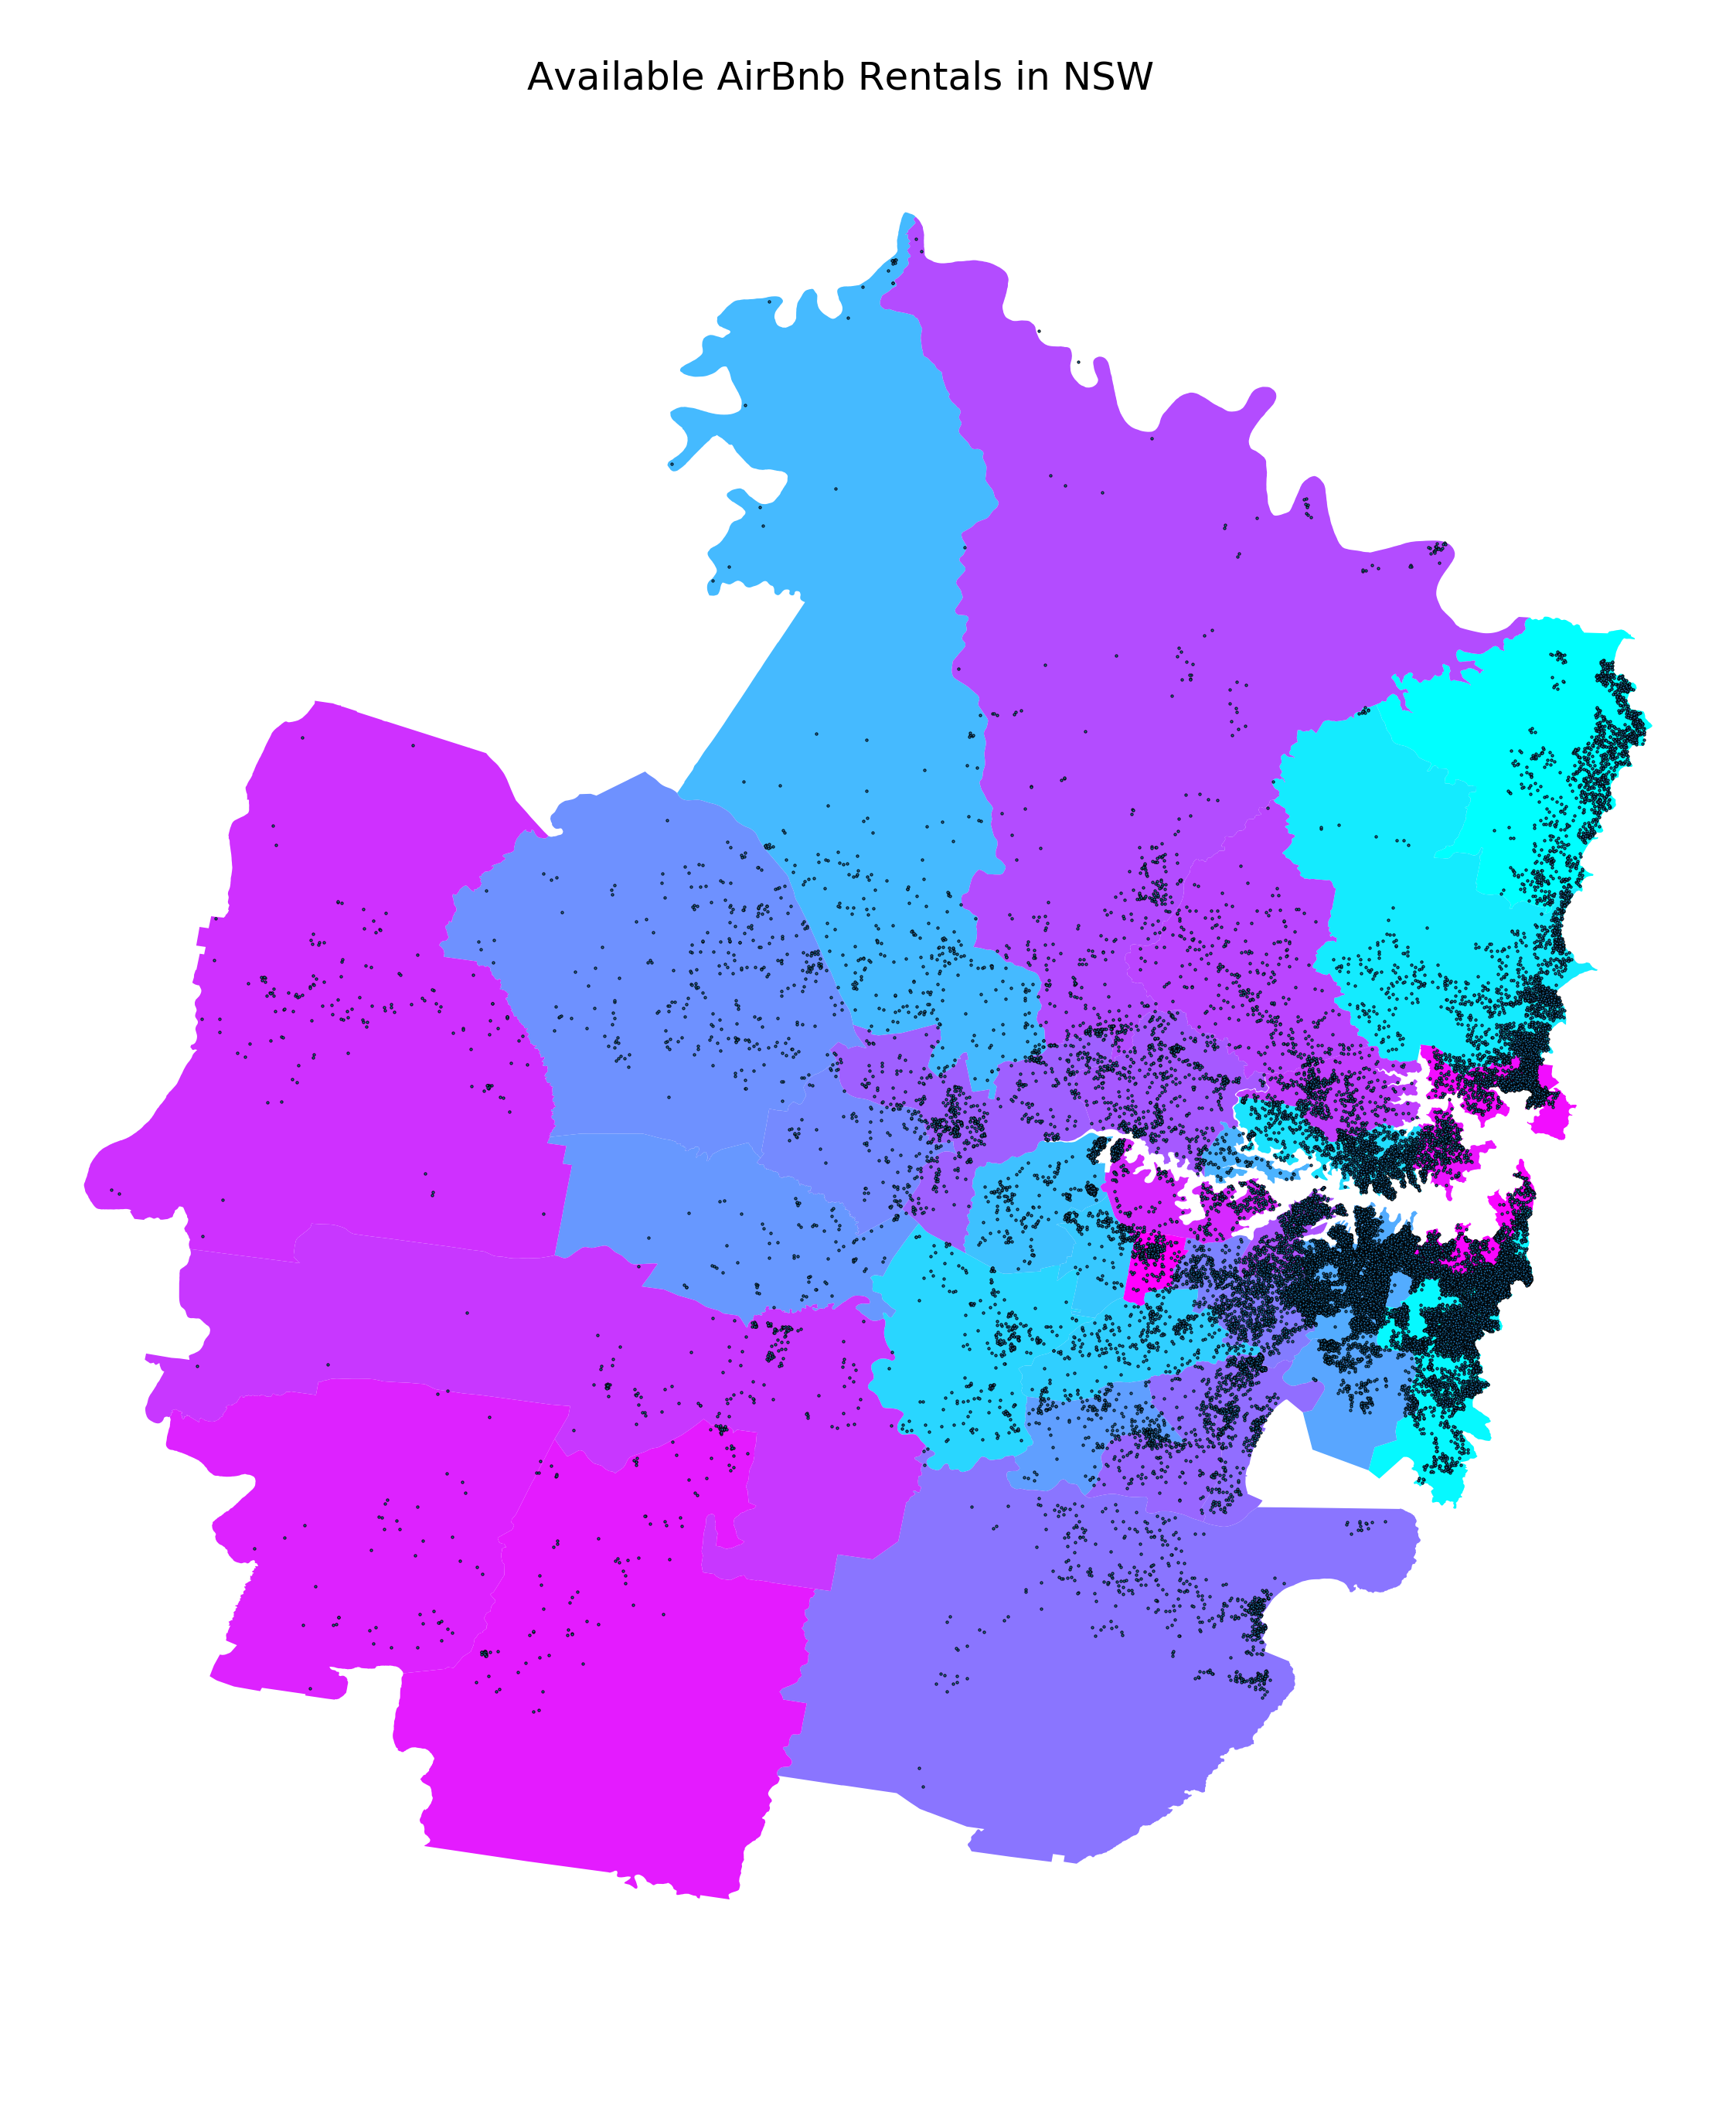

In [63]:
# IMPORTANT SETUP to ensure we are able to plot two DataFrame in the same graph
f, ax = plt.subplots(1, figsize=(40, 50))
ax.set_axis_off()
plt.axis('equal')
suburbs.plot(ax=ax, cmap='cool', linewidth=0.5)
geo_listings.plot(markersize=10, categorical=True, legend=True, ax=ax, edgecolor='black');

plt.figtext(.5,.85,"Available AirBnb Rentals in NSW",fontsize=50,ha='center')